In [1]:
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import arbor, neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, nrn, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc

numprocs=1


In [2]:
shutil.copyfile('mn.mod','modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
compile_nmodl('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl')
h.nrn_load_dll('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')

nrnivmodl found at /media/rnwatanabe/Data/Renato/Modelo-Motoneuronio/modelpynn/bin/nrnivmodl
Unable to compile NEURON extensions. Output was:
  /bin/sh: 1: /media/rnwatanabe/Data/Renato/Modelo-Motoneuronio/modelpynn/bin/nrnivmodl: not found



0.0

In [3]:
# input_rate = 100
# refractory_period = RandomDistribution('uniform', [2.0, 3.0], rng=NumpyRNG(seed=4242))
# v_init = RandomDistribution('uniform', (-70.0, -60.0))
# ctx_parameters = {
#     'cm': 0.25, 'tau_m': 20.0, 'v_rest': -60, 'v_thresh': -50, 'tau_refrac': refractory_period,
#     'v_reset': -60, 'v_spike': -50.0, 'a': 1.0, 'b': 0.005, 'tau_w': 600, 'delta_T': 2.5,
#     'tau_syn_E': 5.0, 'e_rev_E': 0.0, 'tau_syn_I': 10.0, 'e_rev_I': -80 }
# cortical_type = sim.EIF_cond_exp_isfa_ista(**ctx_parameters)

In [4]:
class KsChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    translations = build_translations(
        ('conductance_density', 'gk_slow'),
        ('e_rev', 'eks'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'p': ('motoneuron', 'p'),
    }
    default_initial_values = {
        'p': 1,  # initial value for gating variable m
    }
    units = {
        'iks': 'mA/cm2',
        'p': 'dimensionless',
    }
    recordable = ['iks','p']
    model = "motoneuron"
    conductance_density_parameter = 'gk_slow'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [5]:
class KfChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    recordable = ['ikf','n'] 
    translations = build_translations(
        ('conductance_density', 'gk_fast'),
        ('e_rev', 'ekf'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'n': ('motoneuron', 'n'),
    }
    default_initial_values = {
        'n': 1,  # initial value for gating variable m
    }
    units = {
        'ikf': 'mA/cm2',
        'n': 'dimensionless',
    }
    model = "motoneuron"
    conductance_density_parameter = 'gk_fast'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [6]:
class NaChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": 50,
        "vt":-57.65,
    }
    
    default_initial_values = {
        'm': 1.0,  # initial value for gating variable m
        'h': 0.0,  # initial value for gating variable h
    }
    recordable = ['ina', 'm', 'h']
    units = {
        'ina': 'mA/cm2',
        'm': 'dimensionless',
        'h': 'dimensionless',
    }
    translations = build_translations(
        ('conductance_density', 'gna'),
        ('e_rev', 'ena'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'h': ('motoneuron', 'h'),
        'm': ('motoneuron', 'm'),
        'ina': ('motoneuron', 'ina'),
    }
    model = "motoneuron"
    conductance_density_parameter = 'gna'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [7]:
class PassiveLeak(StandardIonChannelModel):
    translations = build_translations(
        ('conductance_density', 'gl'),
        ('e_rev', 'el'),
    )
    variable_translations = {}
    model = "motoneuron"
    conductance_density_parameter = 'gl'

In [8]:
soma1 = Segment(proximal=P(x=77.5, y=0, z=0, diameter=77.5),
               distal=P(x=0, y=0, z=0, diameter=77.5),
               name="soma", id=0)
soma2 = Segment(proximal=P(x=82.5, y=0, z=0, diameter=82.5),
               distal=P(x=0, y=0, z=0, diameter=82.5),
               name="soma", id=0)
dend1 = Segment(proximal=P(x=0, y=0, z=0, diameter=41.5),
               distal=P(x=-5500, y=0, z=0, diameter=41.5),
               name="dendrite",
               parent=soma1, id=1)
dend2 = Segment(proximal=P(x=0, y=0, z=0, diameter=62.5),
               distal=P(x=-6789, y=0, z=0, diameter=62.5),
               name="dendrite",
               parent=soma2, id=1)

class cell_class(sim.MultiCompartmentNeuron):


    def __init__(self, **parameters):

        self.label = "mn1"
        self.ion_channels = {'pas_soma': PassiveLeak, 'pas_dend': sim.PassiveLeak,
                           'na': NaChannel, 'kf': KfChannel, 'ks': KsChannel}
        self.units = {'v':'mV',
                      'gsyn_exc': 'uS',
                      'gsyn_inh': 'uS',
                      'na.m': 'dimensionless', 'na.h': 'dimensionless', 'kf.n': 'dimensionless', 'ks.p': 'dimensionless',
                      'na.ina': 'mA/cm2', 'kf.ikf': 'mA/cm2', 'ks.iks': 'mA/cm2'}
        self.post_synaptic_entities = {'AMPA': sim.CondExpPostSynapticResponse}
        print('10', parameters)
        super(cell_class, self).__init__(**parameters)
    
   


In [9]:
cell_type = cell_class(
    morphology=[NeuroMLMorphology(Morphology(segments=(soma1, 
                                                       dend1))),
                NeuroMLMorphology(Morphology(segments=(soma2, 
                                                       dend2)))],
    cm=1,    # mF / cm**2
    Ra=70
    ,  # ohm.cm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 30), "vt":[-57.65, -53]},
    kf = {"conductance_density": uniform('soma', 4), "vt":[-57.65, -53]},
    ks = {"conductance_density": uniform('soma', 1), "vt":[-57.65, -53]},

    AMPA={
        "locations": centre('dendrite'),  # number per µm
        "e_syn": 0,
        "tau_syn": 0.6
    },  
)

10 {'morphology': [<pyNN.morphology.NeuroMLMorphology object at 0x7f172a979780>, <pyNN.morphology.NeuroMLMorphology object at 0x7f172a97a680>], 'cm': 1, 'Ra': 70, 'ionic_species': {'na': <pyNN.parameters.IonicSpecies object at 0x7f172a97a650>, 'ks': <pyNN.parameters.IonicSpecies object at 0x7f172a97b6a0>, 'kf': <pyNN.parameters.IonicSpecies object at 0x7f172a97b4c0>}, 'pas_soma': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x7f172a97b460>, 'e_rev': -70}, 'pas_dend': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x7f172a97b280>, 'e_rev': -70}, 'na': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x7f172a978400>, 'vt': [-57.65, -53]}, 'kf': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x7f172a9784c0>, 'vt': [-57.65, -53]}, 'ks': {'conductance_density': <pyNN.neuron.morphology.uniform object at 0x7f172a9786d0>, 'vt': [-57.65, -53]}, 'AMPA': {'locations': <pyNN.neuron.morphology.centre object at 0x7f172a97897

In [10]:
cells = sim.Population(2, cell_type, initial_values={'v': [-70, -70]})

5 cell_class(<parameters>) cell_class(<parameters>) <class 'pyNN.neuron.standardmodels.cells.mn1'>
7 <class 'pyNN.neuron.standardmodels.cells.mn1'> {'morphology': <pyNN.morphology.NeuroMLMorphology object at 0x7f172a97a440>, 'cm': 1, 'Ra': 70.0, 'ionic_species': {'na': <pyNN.parameters.IonicSpecies object at 0x7f172a97abc0>, 'ks': <pyNN.parameters.IonicSpecies object at 0x7f172a97af20>, 'kf': <pyNN.parameters.IonicSpecies object at 0x7f172a97b610>}, 'pas_soma': {'gl': <pyNN.neuron.morphology.uniform object at 0x7f172a979cf0>, 'el': -70.0}, 'pas_dend': {'g': <pyNN.neuron.morphology.uniform object at 0x7f172a979ae0>, 'e': -70.0}, 'na': {'gna': <pyNN.neuron.morphology.uniform object at 0x7f172a979540>, 'ena': 50.0, 'vt': -57.65}, 'kf': {'gk_fast': <pyNN.neuron.morphology.uniform object at 0x7f172a979360>, 'ekf': -80.0, 'vt': -57.65}, 'ks': {'gk_slow': <pyNN.neuron.morphology.uniform object at 0x7f172a979330>, 'eks': -80.0, 'vt': -57.65}, 'AMPA': {'locations': <pyNN.neuron.morphology.centr

In [11]:
cells[0]._cell.synaptic_receptors

{'AMPA': defaultdict(list, {1: [ExpSyn[0]]})}

In [12]:
def generate_spike_times(i):
    input_rate = 150
    number = int(2 * 100 * input_rate / 1000.0)
    gen = lambda: neuron.Sequence(np.add.accumulate(np.random.exponential(1000.0 / input_rate, size=number)))
    if hasattr(i, "__len__"):
        return [gen() for j in i]
    else:
        return gen()
assert generate_spike_times(0).max() > 100

In [13]:
generate_spike_times([0,1])

[Sequence([  0.48393337   7.99144905  29.75806992  35.9449385   36.16585331
   39.29464953  39.58955652  45.69217713  53.3571712   54.7519037
   66.74309014  70.06178202  83.96464997  93.82674083 104.44079033
  121.28211727 151.03288083 154.66512007 154.87653579 176.78145952
  178.66436341 180.71437336 182.28301805 193.83605021 195.36678457
  207.88499377 208.5931703  213.80561446 230.1531158  233.51856838]),
 Sequence([ 26.71874292  31.49519444  35.09390727  37.81971956  38.07168321
   47.72327781  48.52585025  49.11449473  50.00783555  52.84780348
   55.02955342  79.05544807  84.74328063  97.02763415 103.16013634
  110.62769778 111.33921732 123.27453988 123.81182718 127.1848844
  142.75076416 148.22330064 152.95931832 178.50079959 181.11235434
  202.32782554 202.9353782  206.75641356 211.86310313 218.05151327])]

In [14]:


np.random.seed(26278342)
spike_source = sim.Population(400, sim.SpikeSourceArray(spike_times=generate_spike_times))
step_current_dend = sim.DCSource(amplitude=700, start=0, stop=50)
#step_current.inject_into(cells[1:2], location=apical_dendrites(fraction_along=0.9))
#step_current.inject_into(cells[1:2], location=random(after_branch_point(3)(apical_dendrites))
random_location = random_placement('dendrite')
# step_current_dend.inject_into(cells[0:2], location='dendrite')

5 SpikeSourceArray(<parameters>) SpikeSourceArray(<parameters>) <class 'pyNN.neuron.cells.VectorSpikeSource'>
7 <class 'pyNN.neuron.cells.VectorSpikeSource'> {'spike_times': Sequence([  3.39898704   3.54006556   7.46722731  14.45916143  35.14610939
  45.16525751  52.59528514  52.76914177  75.7355653   82.89722483
  83.62006824  86.13849077  86.93373706  90.99637004 105.03406847
 106.14432731 109.44910181 116.7310557  142.22886854 142.79939039
 154.02664843 157.82085254 159.4800105  169.48897814 170.57907448
 186.3095612  200.25301038 202.20005385 208.94440743 228.35603722])} (<class 'pyNN.neuron.cells.VectorSpikeSource'>, <class 'neuron.hclass3.VecStim'>, <class 'neuron.hclass3.HocBaseObject'>, <class 'hoc.HocObject'>, <class 'object'>)
7 <class 'pyNN.neuron.cells.VectorSpikeSource'> {'spike_times': Sequence([  0.83839645   2.39710295   2.49138085   5.41946194  15.31736543
  25.92511744  29.45788502  30.69740356  37.89267547  40.67761946
  41.19234491  60.60403572  64.29919875  70.5654

In [15]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


In [16]:
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.9, location_selector='dendrite'), syn, 
                             receptor_type="AMPA")


In [17]:
sim.run(100)

100.00000000001417

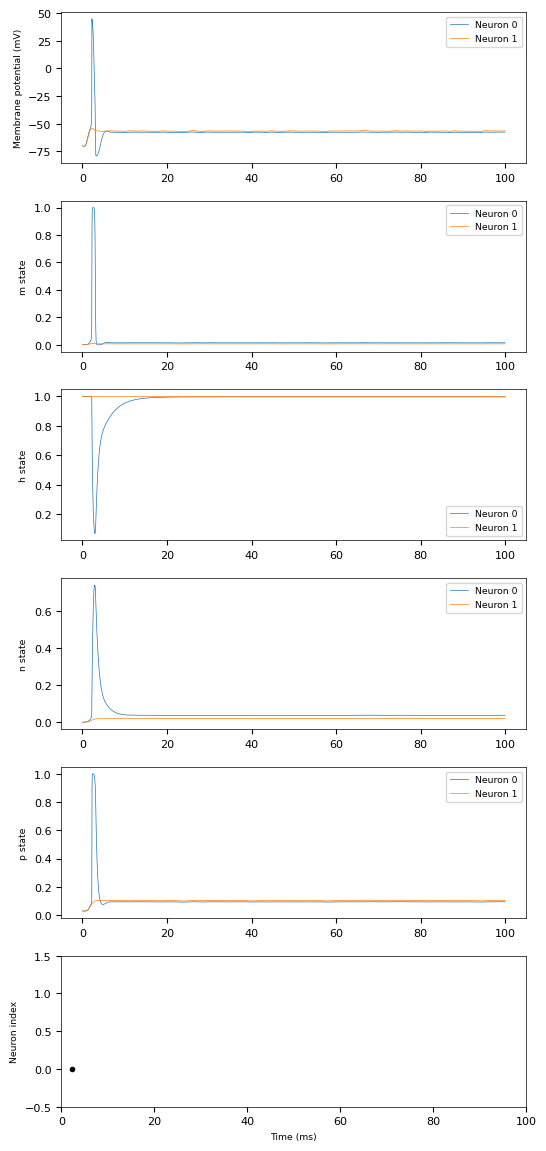

In [18]:
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


In [19]:
data

Segment with [<AnalogSignal(array([[-70.        , -70.        ],
       [-70.09922778, -70.07646407],
       [-70.16376352, -70.12051697],
       ...,
       [-57.5253708 , -56.29883486],
       [-57.52711681, -56.29774144],
       [-57.52944048, -56.297502  ]]) * mV, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[0.00000000e+00, 0.00000000e+00],
       [9.00406027e-05, 4.15453134e-05],
       [1.77166805e-04, 8.17693786e-05],
       ...,
       [3.80258892e-02, 2.10981321e-02],
       [3.80329875e-02, 2.11089474e-02],
       [3.80397300e-02, 2.11195875e-02]]) * dimensionless, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[-70.        , -70.        ],
       [-70.00000008, -70.00000006],
       [-70.00000068, -70.00000047],
       ...,
       [ 62.64501303,  53.41244342],
       [ 62.66466362,  53.3969544 ],
       [ 62.82690491,  53.51046129]]) * mV, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[0.02931223, 0.

In [20]:
A = 77.5*3.14*77.5+2*3.14*(77.5/2)**2
g = 1/1150
g/A

3.0738158628686215e-08

In [21]:
1/1000/14.4

6.944444444444444e-05